In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    !pip3 install torch matplotlib torchmetrics scikit-image segmentation-models-pytorch &> /dev/null

In [ ]:
# !pip install -U giotto-tda &> /dev/null
!pip install torch_topological &> /dev/null

In [ ]:
import torch
from torch import nn as nn
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torchvision.datasets.utils import download_url

from torch import Tensor

import torchmetrics
import segmentation_models_pytorch as smp

import random
import numpy as np
import matplotlib.pyplot as plt
import os

from pprint import pformat
from skimage.transform import resize
from pathlib import Path
from glob import glob
from matplotlib.pyplot import imread
from collections import defaultdict

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import statistics
import cv2

import torch.nn.functional as F

# from gtda.homology import VietorisRipsPersistence, CubicalPersistence, WeakAlphaPersistence
# from gtda.diagrams import PersistenceEntropy, PairwiseDistance, Amplitude

from torch_topological.nn import AlphaComplex, VietorisRipsComplex, CubicalComplex, WassersteinDistance, SignatureLoss

In [ ]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


In [ ]:
data_path = '/content/drive/MyDrive/code/datasets'

batch_size = 4

epochs = 200

lr = 0.0001

# loss = loss_1 * alpha + loss_2 * (1-alpha)
alpha = 0.99

crop_size = (64,64)
padding = 2

In [ ]:
# class DriveDataset(Dataset):
#     def __init__(self, root: str, data_type: str):
#         super(DriveDataset, self).__init__()
#         self.flag = data_type
#         data_root = os.path.join(root, "DRIVE", self.flag)
#         assert os.path.exists(data_root), f"path '{data_root}' does not exists."
#         img_names = [i for i in os.listdir(os.path.join(data_root, "images")) if i.endswith(".tif")]
#         self.img_list = [os.path.join(data_root, "images", i) for i in img_names]
#         self.manual_list = [os.path.join(data_root, "1st_manual", i.split("_")[0] + "_manual1.gif") for i in img_names]
#         self.roi_mask = [os.path.join(data_root, "mask", i.split("_")[0] + f"_{self.flag}_mask.gif") for i in img_names]

#         self.imLst = [i for i in img_names]

#     def __getitem__(self, idx):
#         img = Image.open(self.img_list[idx]).convert('RGB')
#         img = T.functional.resize(img, [512, 512])
#         img = np.array(img) / 255
#         img = np.transpose(img, (2, 0, 1))
#         img = torch.tensor(img, dtype=torch.float32)

#         manual = Image.open(self.manual_list[idx]).convert('L')
#         manual = T.functional.resize(manual, [512, 512])
#         manual = np.array(manual) / 255
#         # roi_mask = Image.open(self.roi_mask[idx]).convert('L')
#         # roi_mask = 255 - np.array(roi_mask)
#         # mask = np.clip(manual + roi_mask, a_min=0, a_max=255)
#         mask = manual[np.newaxis, ...]
#         mask = torch.tensor(mask, dtype=torch.float32)

#         # print(img)
#         # print(mask.size())

#         # img = Image.fromarray(img)
#         # mask = Image.fromarray(mask)

#         return img, mask

#     def __len__(self):
#         return len(self.img_list)

#     def show(self):
#         return self.imLst

In [ ]:
# class DriveDataset(Dataset):
#     def __init__(self, root: str, data_type: str, crop_size=(256, 256)):
#         super(DriveDataset, self).__init__()
#         self.flag = data_type
#         self.crop_size = crop_size
#         data_root = os.path.join(root, "DRIVE", self.flag)
#         assert os.path.exists(data_root), f"path '{data_root}' does not exists."
#         img_names = [i for i in os.listdir(os.path.join(data_root, "images")) if i.endswith(".tif")]
#         self.img_list = [os.path.join(data_root, "images", i) for i in img_names]
#         self.manual_list = [os.path.join(data_root, "1st_manual", i.split("_")[0] + "_manual1.gif") for i in img_names]
#         self.roi_mask = [os.path.join(data_root, "mask", i.split("_")[0] + f"_{self.flag}_mask.gif") for i in img_names]

#         self.imLst = [i for i in img_names]

#     def __getitem__(self, idx):
#         img = Image.open(self.img_list[idx]).convert('RGB')
#         manual = Image.open(self.manual_list[idx]).convert('L')

#         # 应用裁剪
#         i, j, h, w = T.RandomCrop.get_params(img, output_size=self.crop_size)
#         img = T.functional.crop(img, i, j, h, w)
#         manual = T.functional.crop(manual, i, j, h, w)

#         img = T.functional.to_tensor(img)
#         manual = T.functional.to_tensor(manual)
#         mask = manual

#         return img, mask

#     def __len__(self):
#         return len(self.img_list)

#     def show(self):
#         return self.imLst

In [ ]:
# class DriveDataset(Dataset):
#     def __init__(self, root: str, data_type: str, crop_size=(256, 256)):
#         super(DriveDataset, self).__init__()
#         self.flag = data_type
#         self.crop_size = crop_size
#         data_root = os.path.join(root, "DRIVE", self.flag)
#         assert os.path.exists(data_root), f"path '{data_root}' does not exist."
#         img_names = [i for i in os.listdir(os.path.join(data_root, "images")) if i.endswith(".tif")]
#         self.img_list = [os.path.join(data_root, "images", i) for i in img_names]
#         self.manual_list = [os.path.join(data_root, "1st_manual", i.split("_")[0] + "_manual1.gif") for i in img_names]
#         self.roi_mask = [os.path.join(data_root, "mask", i.split("_")[0] + f"_{self.flag}_mask.gif") for i in img_names]

#         self.imLst = [i for i in img_names]

#     def __getitem__(self, idx):
#         img = Image.open(self.img_list[idx]).convert('RGB')
#         manual = Image.open(self.manual_list[idx]).convert('L')
#         mask = Image.open(self.roi_mask[idx]).convert('L')

#         i, j, h, w = T.RandomCrop.get_params(img, output_size=self.crop_size)
#         img = T.functional.crop(img, i, j, h, w)
#         manual = T.functional.crop(manual, i, j, h, w)
#         mask = T.functional.crop(mask, i, j, h, w)

#         img = T.functional.to_tensor(img)
#         manual = T.functional.to_tensor(manual)
#         mask = T.functional.to_tensor(mask)

#         img = img * mask
#         manual = manual * mask

#         return img, manual

#     def __len__(self):
#         return len(self.img_list)

#     def show(self):
#         return self.imLst

In [ ]:
class DriveDataset(Dataset):
    def __init__(self, root: str, data_type: str, crop_size=(60, 60), padding=2):
        super(DriveDataset, self).__init__()
        self.flag = data_type
        self.crop_size = crop_size
        self.padding = padding
        data_root = os.path.join(root, "DRIVE", self.flag)
        assert os.path.exists(data_root), f"path '{data_root}' does not exist."
        img_names = [i for i in os.listdir(os.path.join(data_root, "images")) if i.endswith(".tif")]
        self.img_list = [os.path.join(data_root, "images", i) for i in img_names]
        self.manual_list = [os.path.join(data_root, "1st_manual", i.split("_")[0] + "_manual1.gif") for i in img_names]
        self.roi_mask = [os.path.join(data_root, "mask", i.split("_")[0] + f"_{self.flag}_mask.gif") for i in img_names]

        self.imLst = [i for i in img_names]

    def __getitem__(self, idx):
        img = Image.open(self.img_list[idx]).convert('RGB')
        manual = Image.open(self.manual_list[idx]).convert('L')
        mask = Image.open(self.roi_mask[idx]).convert('L')

        img_width, img_height = img.size
        start_i = (img_height - self.crop_size[1]) // 6
        start_j = (img_width - self.crop_size[0]) // 2

        img = TF.crop(img, start_i, start_j, self.crop_size[1], self.crop_size[0])
        manual = TF.crop(manual, start_i, start_j, self.crop_size[1], self.crop_size[0])
        mask = TF.crop(mask, start_i, start_j, self.crop_size[1], self.crop_size[0])

        img = T.functional.to_tensor(img)
        manual = T.functional.to_tensor(manual)
        mask = T.functional.to_tensor(mask)

        img = img * mask
        manual = manual * mask

        # padding = self.padding
        # img = TF.pad(img, padding=[padding, padding, padding, padding], fill=1)
        # manual = TF.pad(manual, padding=[padding, padding, padding, padding], fill=1)
        # mask = TF.pad(mask, padding=[padding, padding, padding, padding], fill=0)

        return img, manual

    def __len__(self):
        return len(self.img_list)

    def show(self):
        return self.imLst

In [ ]:
train_set = DriveDataset(data_path, data_type="training", crop_size=crop_size, padding = padding)
test_set = DriveDataset(data_path, data_type="test", crop_size=crop_size, padding = padding)

print(len(train_set))
print(len(test_set))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

20
20


torch.Size([4, 3, 64, 64])
torch.Size([4, 1, 64, 64])


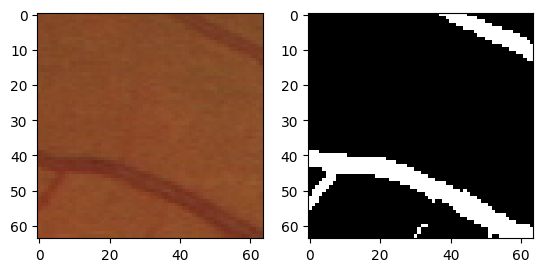

torch.Size([4, 3, 64, 64])
torch.Size([4, 1, 64, 64])


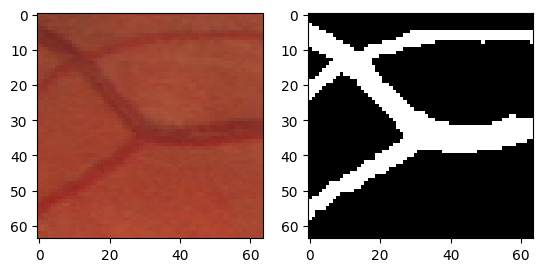

torch.Size([4, 3, 64, 64])
torch.Size([4, 1, 64, 64])


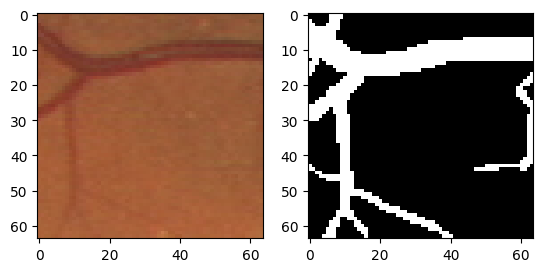

torch.Size([4, 3, 64, 64])
torch.Size([4, 1, 64, 64])


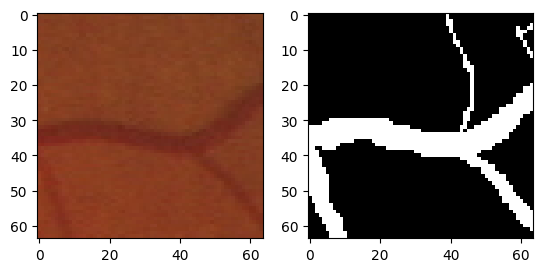

torch.Size([4, 3, 64, 64])
torch.Size([4, 1, 64, 64])


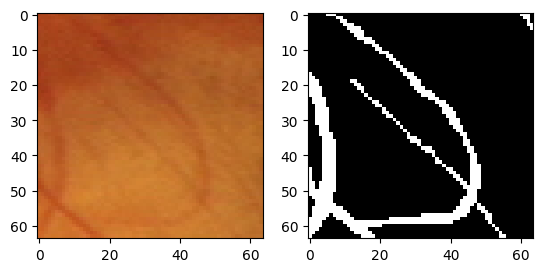

In [ ]:
for batch_x, batch_y in train_loader:
    print(batch_x.size())
    print(batch_y.size())
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.imshow(batch_y[0][0], cmap=plt.get_cmap('gray'))
    plt.show()

In [ ]:
def plot_image_with_segmentation(image, segmentation, ax=None, model='gray'):
    """
    Plots an image with overlayed segmentation mask. Segmentation is thresholded at 0.5

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    im = image.cpu().detach().numpy()
    segm = segmentation.cpu().detach().numpy()
    if model == 'gray':
        ax.imshow(im.squeeze(), cmap="gray")
    elif model == 'rgb':
        ax.imshow(np.transpose(im.squeeze(), (1, 2, 0)))
    mask = segm < 0.5
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax

In [ ]:
def evaluate_model_on_single_image(model, x, device=device):
    """
    Evaluate a model on a single data point on the device.

    Returns: model(x)
    """
    with torch.no_grad():
        x = x.to(device)
        return model(x.view(1, *x.shape))

In [ ]:
def evaluate_model(model, data_loader, metrics_dict, reduction=True, device=device, alpha=0.5):
    """
    Evaluate a model 'model' on all batches of a torch DataLoader 'data_loader'.
    On each batch, compute all metric functions stored in dictionary 'metrics_dict'.

    Returns: dict of metric_name: (list of batch-wise metrics if reduction == False, else single scalar)
    """

    # defaultdict(list) returns a dictionary-like object with default_factory list.
    # When a new key is encountered, an entry is automatically created of type default_factory.
    metrics = defaultdict(list)
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(data_loader):
            # Predict on batch
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = model(batch_x)

            if alpha == 0.0:
                for metric_name, metric_func in metrics_dict.items():
                    value_1 = 0
                    value_2 = metric_func[1](logits.cpu(), batch_y.cpu()).item()

                    value = alpha*value_1 + (1-alpha)*value_2

                    metrics[metric_name].append(value)

            elif alpha == 1.0:
                for metric_name, metric_func in metrics_dict.items():
                    value_1 = metric_func[0](logits.cpu(), batch_y.cpu()).item() #.cpu().numpy()
                    value_2 = 0

                    value = alpha*value_1 + (1-alpha)*value_2

                    metrics[metric_name].append(value)

            else:
                for metric_name, metric_func in metrics_dict.items():
                    value_1 = metric_func[0](logits.cpu(), batch_y.cpu()).item() #.cpu().numpy()
                    value_2 = metric_func[1](logits.cpu(), batch_y.cpu()).item()

                    value = alpha*value_1 + (1-alpha)*value_2

                    metrics[metric_name].append(value)

    if reduction == True:
        # Return mean values
        return {key: np.mean(value) for key, value in metrics.items()}
    else:
        return metrics


In [ ]:
def save_model(model, path, optimizer=None):
    """
    Saves the state_dict of a torch model and optional optimizer to 'path'
    Returns: None
    """
    state = {"model": model.state_dict()}
    if optimizer is not None:
        state["optimizer"] = optimizer.state_dict()
    torch.save(state, path)


def load_model(model, path, optimizer=None):
    """
    Loads the state_dict of a torch model and optional optimizer from 'path'
    Returns: None
    """
    state = torch.load(path)
    model.load_state_dict(state["model"])
    if optimizer is not None:
        optimizer.load_state_dict(state["optimizer"])

In [ ]:
def plot_histories(train_history=None, val_history=None, label="Loss"):
    """
    Takes a list of training and/or validation metrics and plots them
    Returns: plt.figure and ax objects
    """
    if not train_history and not val_history:
        raise ValueError("Must specify at least one of 'train_histories' and 'val_histories'")
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)

    epochs = np.arange(len(train_history or val_history))
    if train_history:
        ax.plot(epochs, train_history, label="Training", color="black")
    if val_history:
        ax.plot(epochs, val_history, label="Validation", color="darkred")

    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend(loc=0)

    return fig, ax

In [ ]:
def run_one_epoch(model, loss, optimizer, train_loader, val_loader, n_epochs, metrics_dict, device=device, alpha=0.5):
    """
    Run 1 epoch of training
    Changes to model parameters and optimizer occour internally (state updates)
    Returns:
        two dictionaries, training and a validation metrics
    """
    train_losses = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        # Zero out stored gradients for all parameters
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        print(f"   -- Batch {i+1}/{len(train_loader)}", end=" / ")
        # Predict on batch
        logits = model(batch_x)

        if alpha == 0.0:
            loss_tensor_1 = 0
            loss_tensor_2 = loss[1](logits, batch_y)
        elif alpha == 1.0:
            loss_tensor_1 = loss[0](logits, batch_y)
            loss_tensor_2 = 0
        else:
            # Compute loss function
            loss_tensor_1 = loss[0](logits, batch_y)
            loss_tensor_2 = loss[1](logits, batch_y)

            print(loss_tensor_2)

        loss_tensor = alpha*loss_tensor_1 + (1-alpha)*loss_tensor_2
        loss_scalar = loss_tensor.detach().cpu().numpy()

        train_losses.append(loss_scalar)
        print("Loss: ", loss_scalar)

        # Backprop and step
        loss_tensor.backward()
        optimizer.step()

    # Run validation
    print("   Validation running...")
    val_metrics = evaluate_model(
        model=model,
        data_loader=val_loader,
        metrics_dict=metrics_dict,
        alpha=alpha
    )
    # Return loss and metrics as dicts
    return {"loss": np.mean(train_losses)}, val_metrics


def merge_list_of_dicts(list_of_dicts):
    """
    Takes a list of dictionaries and merges them into a single dictionary pointing to lists

    E.g. [{"loss": 5}, {"loss": 3}, {"loss": -2, "F1": 0.5}] --> {"loss": [5, 3, -2], "F1": [0.5]}

    Returns: dict
    """
    merged = defaultdict(list)
    for dict_ in list_of_dicts:
        for value, key in dict_.items():
            merged[value].append(key)
    return merged


def training_loop(model, loss, optimizer, train_loader, val_loader, n_epochs, init_epoch=None, metrics_dict=None, save_path=None, alpha=0.5):
    """
    Run training of a model given a loss function, optimizer and a set of training and validation data.
    Supports computing additional metrics on the validation set (only) via the metrics_dict param.
    Specify save_path to store the model at each epoch.

    Returns:
        Two lists of metric dictionaries for each epoch for training and validation, specifically
    """
    train_history, val_history = [], []

    metrics_with_loss = {"loss": loss}
    if metrics_dict is not None:
        metrics_with_loss.update(metrics_dict)

    if init_epoch == None:
        init_epoch = 0
    try:
        for i in range(init_epoch, n_epochs):
            print(f"Epoch {i+1}/{n_epochs}")
            train_metrics, val_metrics = run_one_epoch(
                model=model,
                loss=loss,
                optimizer=optimizer,
                train_loader=train_loader,
                val_loader=val_loader,
                n_epochs=n_epochs,
                metrics_dict=metrics_with_loss,
                alpha=alpha
            )
            print("   Mean epoch metrics:")
            print(f"   Training:   {pformat(train_metrics)}")
            print(f"   Validation: {pformat(val_metrics)}")
            train_history.append(train_metrics), val_history.append(val_metrics)

            # wandb.log({'epoch': n_epochs+1, 'loss': train_metrics['loss'], 'val_loss': val_metrics['loss']})
            # wandb.watch(model, loss, log="all")

            # if save_path:
            #     save_path_epoch = f"epoch_{i+1}_{save_path}"
            #     print(f"   Saving to: {save_path_epoch}")
            #     save_model(model, save_path_epoch, optimizer)
            #     old_path_epoch = f"epoch_{i}_{save_path}"
            #     if os.path.exists(old_path_epoch):
            #         os.remove(old_path_epoch)

    except KeyboardInterrupt:
        print("Training stopped.")
        pass

    # Merge list of training and validation dicts into single dicts
    return merge_list_of_dicts(train_history), merge_list_of_dicts(val_history)


In [ ]:
# Init U-Net model
model = smp.Unet(encoder_name='efficientnet-b0',in_channels=3,classes=1)

model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 35.2MB/s]


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [ ]:
# Specify integer, starting at 1
init_epoch = None
if init_epoch != None:
    load_model(model, f"epoch_{init_epoch}_model.ckpt", optimizer)

In [ ]:
def soft_dice(y_true, y_pred):
    smooth = 1
    intersection = torch.sum((y_true * y_pred))
    coeff = (2. * intersection + smooth) / (torch.sum(y_true) + torch.sum(y_pred) + smooth)
    return 1. - coeff


class soft_dice_cldice(nn.Module):
    def __init__(self, iter_=3, alpha=0.5, smooth=1.):
        super(soft_dice_cldice, self).__init__()
        self.iter = iter_
        self.smooth = smooth
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        dice = soft_dice(y_true, y_pred)
        skel_pred = soft_skel(y_pred, self.iter)
        skel_true = soft_skel(y_true, self.iter)
        tprec = (torch.sum(torch.multiply(skel_pred, y_true)) + self.smooth) / (
                    torch.sum(skel_pred) + self.smooth)
        tsens = (torch.sum(torch.multiply(skel_true, y_pred)) + self.smooth) / (
                    torch.sum(skel_true) + self.smooth)
        cl_dice = 1. - 2.0 * (tprec * tsens) / (tprec + tsens)
        return (1.0 - self.alpha) * dice + self.alpha * cl_dice

class soft_cldice(nn.Module):
    def __init__(self, iter_=3, alpha=0.5, smooth=1.):
        super(soft_cldice, self).__init__()
        self.iter = iter_
        self.smooth = smooth
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        skel_pred = soft_skel(y_pred, self.iter)
        skel_true = soft_skel(y_true, self.iter)
        tprec = (torch.sum(torch.multiply(skel_pred, y_true)) + self.smooth) / (
                    torch.sum(skel_pred) + self.smooth)
        tsens = (torch.sum(torch.multiply(skel_true, y_pred)) + self.smooth) / (
                    torch.sum(skel_true) + self.smooth)
        cl_dice = 1. - 2.0 * (tprec * tsens) / (tprec + tsens)
        return cl_dice

def soft_erode(img):
    if len(img.shape) == 4:
        p1 = -F.max_pool2d(-img, (3, 1), (1, 1), (1, 0))
        p2 = -F.max_pool2d(-img, (1, 3), (1, 1), (0, 1))
        return torch.min(p1, p2)
    elif len(img.shape) == 5:
        p1 = -F.max_pool3d(-img, (3, 1, 1), (1, 1, 1), (1, 0, 0))
        p2 = -F.max_pool3d(-img, (1, 3, 1), (1, 1, 1), (0, 1, 0))
        p3 = -F.max_pool3d(-img, (1, 1, 3), (1, 1, 1), (0, 0, 1))
        return torch.min(torch.min(p1, p2), p3)


def soft_dilate(img):
    if len(img.shape) == 4:
        return F.max_pool2d(img, (3, 3), (1, 1), (1, 1))
    elif len(img.shape) == 5:
        return F.max_pool3d(img, (3, 3, 3), (1, 1, 1), (1, 1, 1))


def soft_open(img):
    return soft_dilate(soft_erode(img))


def soft_skel(img, iter_):
    img1 = soft_open(img)
    skel = F.gelu(img - img1)
    for j in range(iter_):
        img = soft_erode(img)
        img1 = soft_open(img)
        delta = F.gelu(img - img1)
        skel = skel + F.gelu(delta - skel * delta)
    return skel

from skimage.morphology import skeletonize

def skel(img, iter_):
    img_tensor = img.detach().cpu().numpy()
    threshold = 0.5
    binary_image = (img_tensor > threshold).astype(np.uint8)
    skeletonized_tensor = torch.from_numpy(np.stack([skeletonize(im) for im in binary_image])).float().to('cuda:0')
    return skeletonized_tensor


class cldice(nn.Module):
    def __init__(self, iter_=3, alpha=0.5, smooth=1.):
        super(cldice, self).__init__()
        self.iter = iter_
        self.smooth = smooth
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        skel_pred = skel(y_pred, self.iter)
        skel_true = skel(y_true, self.iter)
        tprec = (torch.sum(torch.multiply(skel_pred, y_true)) + self.smooth) / (
                    torch.sum(skel_pred) + self.smooth)
        tsens = (torch.sum(torch.multiply(skel_true, y_pred)) + self.smooth) / (
                    torch.sum(skel_true) + self.smooth)
        cl_dice = 1. - 2.0 * (tprec * tsens) / (tprec + tsens)
        return cl_dice

In [ ]:
class persistence_loss(nn.Module):
    def __init__(self, dim=1):
        super(persistence_loss, self).__init__()
        self.persistence_algo = CubicalComplex()
        self.loss_fn = WassersteinDistance(q=1)

    def forward(self, y_pred, y_true):
        loss = 0.0
        batch_size = y_pred.size(0)
        for i in range(batch_size):
            pd_y_pred = self.persistence_algo(y_pred[i])
            pd_y_pred = pd_y_pred[0]
            pd_y_true = self.persistence_algo(y_true[i])[0]
            pd_y_true = pd_y_true[0]

            loss += self.loss_fn(pd_y_pred, pd_y_true)

        loss /= batch_size
        return loss

In [ ]:
# Define loss and metrics
loss_1 = torch.nn.MSELoss(reduction="mean")
loss_2 = persistence_loss(dim=1)

# metrics = {"f1": torchmetrics.classification.F1Score(task='binary', num_classes=1, average="macro", mdmc_average="samplewise")}
metrics = {}

In [ ]:
# Run training
train_history, val_history = training_loop(
    model=model,
    loss=[loss_1, loss_2],
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,
    init_epoch=init_epoch,
    n_epochs=epochs,
    metrics_dict=metrics,
    save_path="model.ckpt",
    alpha=alpha
)

Epoch 1/200
   -- Batch 1/5 / tensor(82.7399, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.6118724


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


   -- Batch 2/5 / tensor(76.5166, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.5255165
   -- Batch 3/5 / tensor(85.3135, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.637281
   -- Batch 4/5 / tensor(78.8501, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.5106263
   -- Batch 5/5 / tensor(79.5738, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.5439396
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 1.5658472}
   Validation: {'loss': 1.5626034621894367}
Epoch 2/200
   -- Batch 1/5 / tensor(73.8561, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.4656005
   -- Batch 2/5 / tensor(79.1219, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.522775
   -- Batch 3/5 / tensor(69.1031, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.4245796
   -- Batch 4/5 / tensor(70.3322, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.3452431
   -- Batch 5/5 / tensor(75.4533, device='cuda:0', grad_fn=<DivBackward0>)
Loss:  1.4010935
   Validation running...
   Mean ep

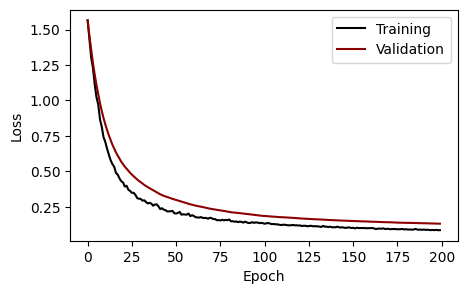

In [ ]:
plot_histories(train_history['loss'], val_history['loss'], label="Loss")
# plot_histories(train_history=None, val_history=val_history['f1'], label="F1 Score")
plt.show()

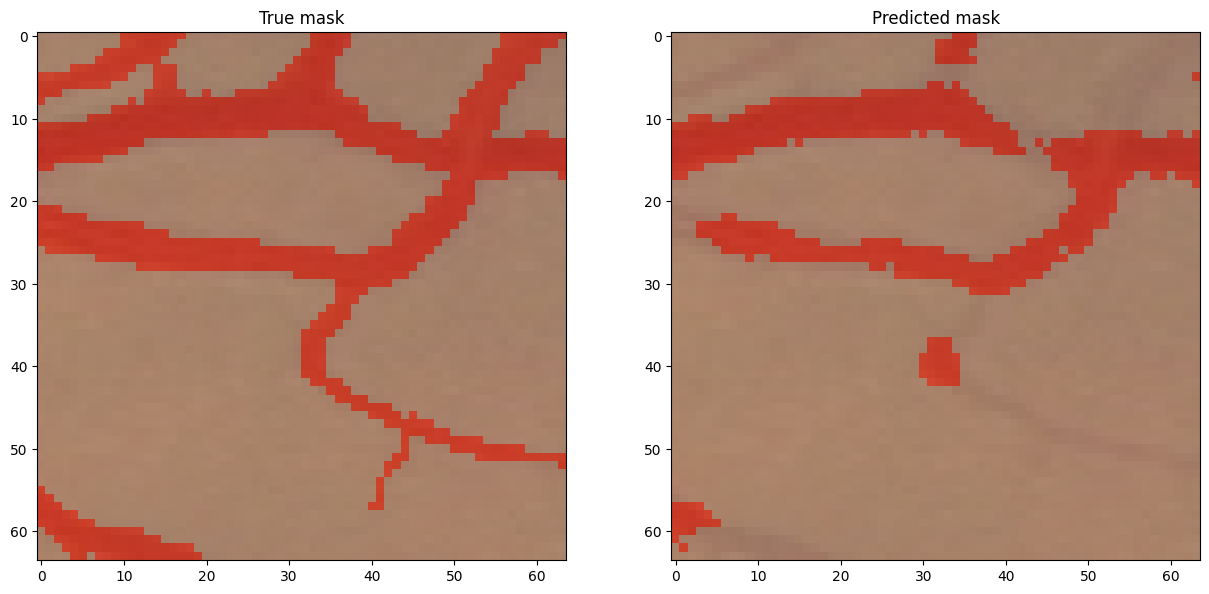

In [ ]:
# Select a test image
x,y = test_set[0]
pred = evaluate_model_on_single_image(model, x)

# Plot the result
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15))
ax1.set_title("True mask")
ax2.set_title("Predicted mask")
plot_image_with_segmentation(x, y, ax=ax1, model='rgb')
plot_image_with_segmentation(x, pred, ax=ax2, model='rgb')
plt.show()

In [ ]:
class SegmentationMetric(object):
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = np.zeros((self.numClass,) * 2)  # 混淆矩阵（空）

    def pixelAccuracy(self):
        # return all class overall pixel accuracy 正确的像素占总像素的比例
        #  PA = acc = (TP + TN) / (TP + TN + FP + TN)
        acc = np.diag(self.confusionMatrix).sum() / self.confusionMatrix.sum()
        return acc

    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = np.diag(self.confusionMatrix) / self.confusionMatrix.sum(axis=1)
        return classAcc  # 返回的是一个列表值，如：[0.90, 0.80, 0.96]，表示类别1 2 3各类别的预测准确率

    def meanPixelAccuracy(self):
        """
        Mean Pixel Accuracy(MPA，均像素精度)：是PA的一种简单提升，计算每个类内被正确分类像素数的比例，之后求所有类的平均。
        :return:
        """
        classAcc = self.classPixelAccuracy()
        meanAcc = np.nanmean(classAcc)  # np.nanmean 求平均值，nan表示遇到Nan类型，其值取为0
        return meanAcc  # 返回单个值，如：np.nanmean([0.90, 0.80, 0.96, nan, nan]) = (0.90 + 0.80 + 0.96） / 3 =  0.89

    def IntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = np.diag(self.confusionMatrix)  # 取对角元素的值，返回列表
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(
            self.confusionMatrix)  # axis = 1表示混淆矩阵行的值，返回列表； axis = 0表示取混淆矩阵列的值，返回列表
        IoU = intersection / union  # 返回列表，其值为各个类别的IoU
        return IoU

    def meanIntersectionOverUnion(self):
        mIoU = np.nanmean(self.IntersectionOverUnion())  # 求各类别IoU的平均
        return mIoU

    def genConfusionMatrix(self, imgPredict, imgLabel):  #
        """
        同FCN中score.py的fast_hist()函数,计算混淆矩阵
        :param imgPredict:
        :param imgLabel:
        :return: 混淆矩阵
        """
        # remove classes from unlabeled pixels in gt image and predict
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = np.bincount(label, minlength=self.numClass ** 2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        # print(confusionMatrix)
        return confusionMatrix

    def Frequency_Weighted_Intersection_over_Union(self):
        """
        FWIoU，频权交并比:为MIoU的一种提升，这种方法根据每个类出现的频率为其设置权重。
        FWIOU =     [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)]
        """
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                np.diag(self.confusion_matrix))
        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)  # 得到混淆矩阵
        return self.confusionMatrix

    def reset(self):
        self.confusionMatrix = np.zeros((self.numClass, self.numClass))

In [ ]:
def meanSkeletonAccuracy(x, y):
    skel_x = soft_skel(x)
    skel_y = soft_skel(y)
    metric = SegmentationMetric(2)
    hist = metric.addBatch(skel_x, skel_y)

    return metric.pixelAccuracy()

In [ ]:
threshold = 0.5

imLst_train = train_set.show()
imLst_test = test_set.show()

eval_loss_func = cldice()

22_training.tif:


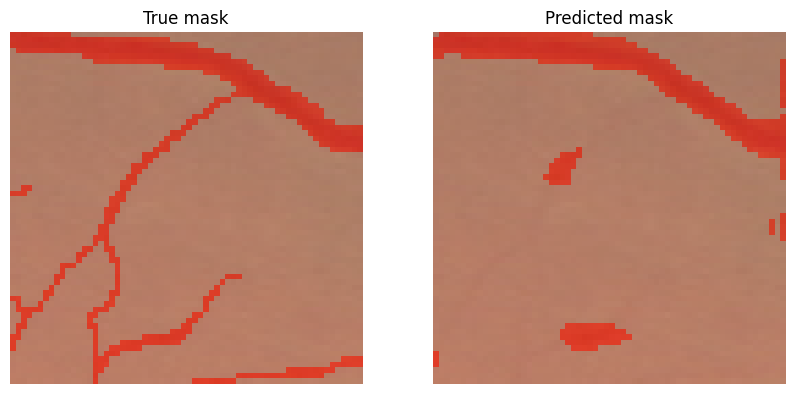

hist:
[[3418.  124.]
 [ 217.  337.]],
iou:[0.90928438 0.49705015],
miou:0.7031672658186724,
PA:0.916748046875,
cPA:[0.96499153 0.60830325],
mPA:0.7866473896531971
clDice: 0.37116605043411255
----------------------------------------
29_training.tif:


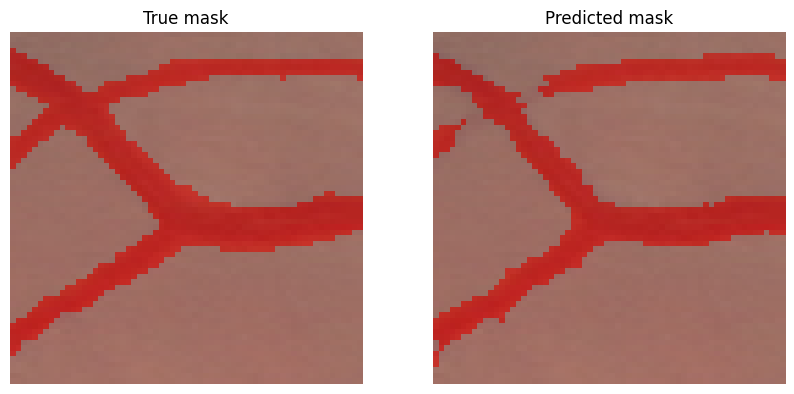

hist:
[[3092.   83.]
 [ 171.  750.]],
iou:[0.92408846 0.74701195],
miou:0.8355502080143264,
PA:0.93798828125,
cPA:[0.97385827 0.81433225],
mPA:0.8940952576367693
clDice: 0.08325773477554321
----------------------------------------
25_training.tif:


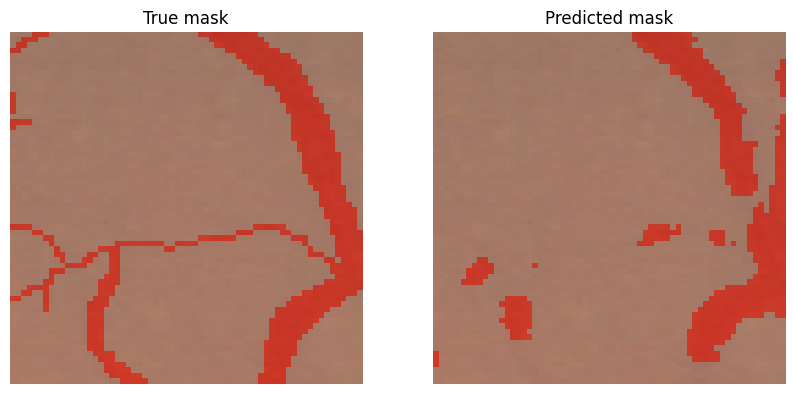

hist:
[[3306.  157.]
 [ 222.  411.]],
iou:[0.89715061 0.52025316],
miou:0.7087018875702042,
PA:0.907470703125,
cPA:[0.95466359 0.6492891 ],
mPA:0.8019763430058862
clDice: 0.38714534044265747
----------------------------------------
26_training.tif:


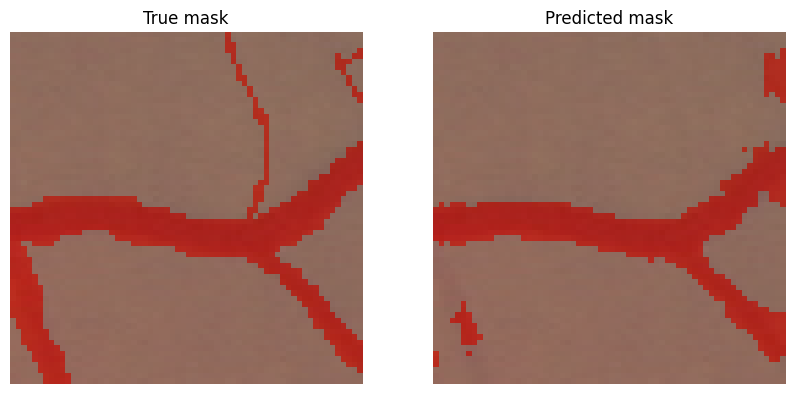

hist:
[[3214.  107.]
 [ 226.  549.]],
iou:[0.90611785 0.62244898],
miou:0.7642834128294679,
PA:0.918701171875,
cPA:[0.96778079 0.7083871 ],
mPA:0.8380839428465969
clDice: 0.25481653213500977
----------------------------------------
24_training.tif:


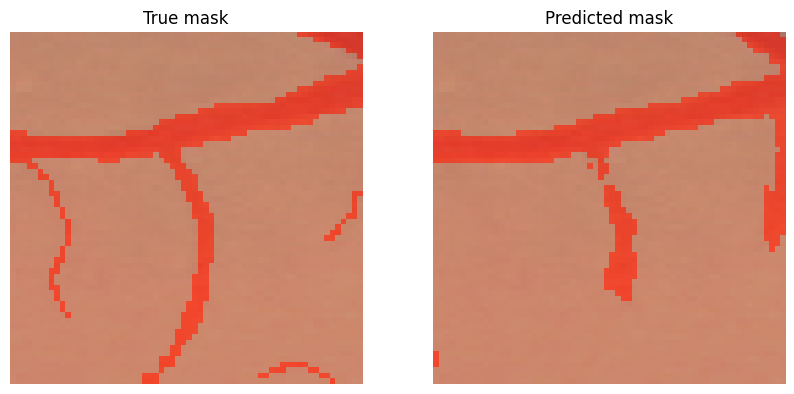

hist:
[[3371.  147.]
 [ 141.  437.]],
iou:[0.92128997 0.60275862],
miou:0.7620242953133982,
PA:0.9296875,
cPA:[0.95821489 0.75605536],
mPA:0.8571351290742026
clDice: 0.31071406602859497
----------------------------------------
30_training.tif:


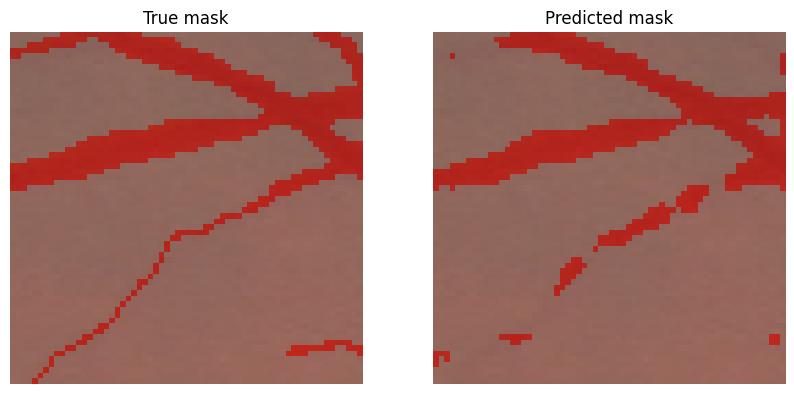

hist:
[[3239.  111.]
 [ 186.  560.]],
iou:[0.91600679 0.65344224],
miou:0.7847245138518562,
PA:0.927490234375,
cPA:[0.96686567 0.75067024],
mPA:0.8587679564643271
clDice: 0.2732424736022949
----------------------------------------
23_training.tif:


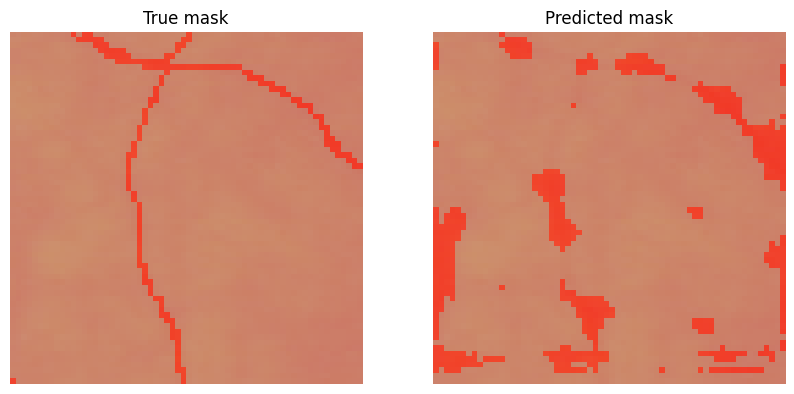

hist:
[[3509.  423.]
 [  78.   86.]],
iou:[0.87506234 0.14650767],
miou:0.5107850051192292,
PA:0.877685546875,
cPA:[0.89242116 0.52439024],
mPA:0.7084057018087984
clDice: 0.7498522996902466
----------------------------------------
31_training.tif:


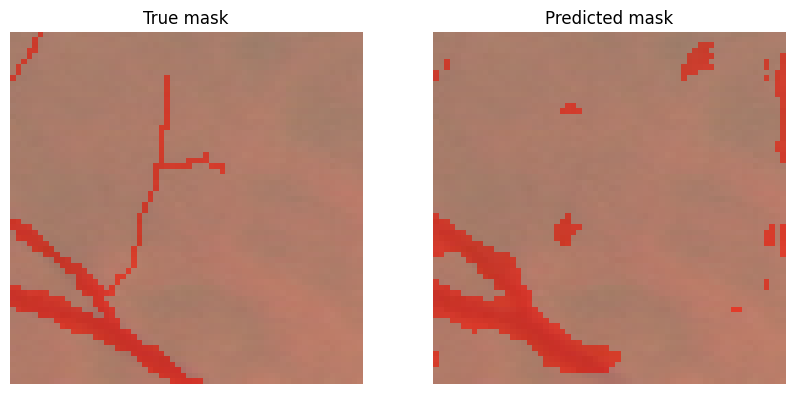

hist:
[[3603.  218.]
 [  75.  200.]],
iou:[0.92479466 0.40567951],
miou:0.6652370871877746,
PA:0.928466796875,
cPA:[0.94294687 0.72727273],
mPA:0.8351097999095906
clDice: 0.4505416750907898
----------------------------------------
21_training.tif:


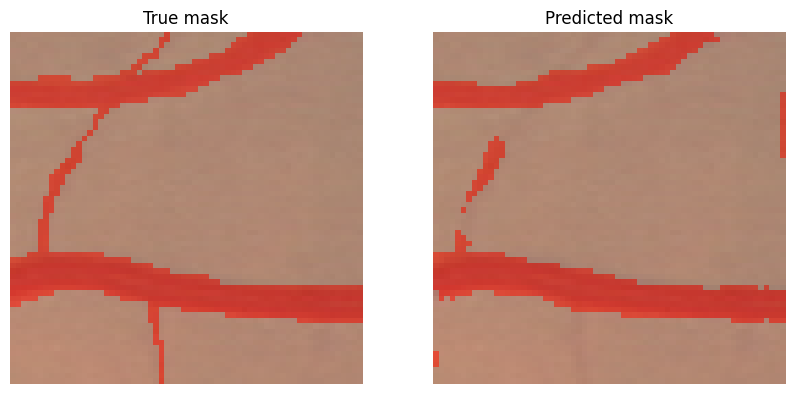

hist:
[[3234.   58.]
 [ 121.  683.]],
iou:[0.94755347 0.79234339],
miou:0.8699484297448747,
PA:0.956298828125,
cPA:[0.98238153 0.84950249],
mPA:0.9159420092731966
clDice: 0.21447443962097168
----------------------------------------
27_training.tif:


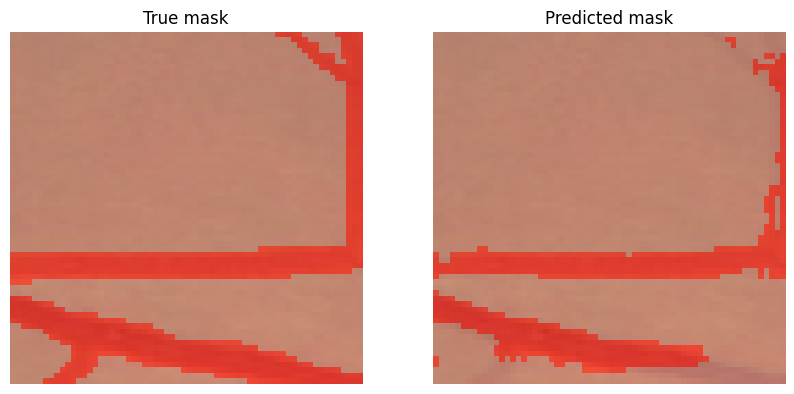

hist:
[[3176.   33.]
 [ 257.  630.]],
iou:[0.91633006 0.68478261],
miou:0.8005563360846986,
PA:0.92919921875,
cPA:[0.98971642 0.7102593 ],
mPA:0.8499878617881009
clDice: 0.17130005359649658
----------------------------------------
28_training.tif:


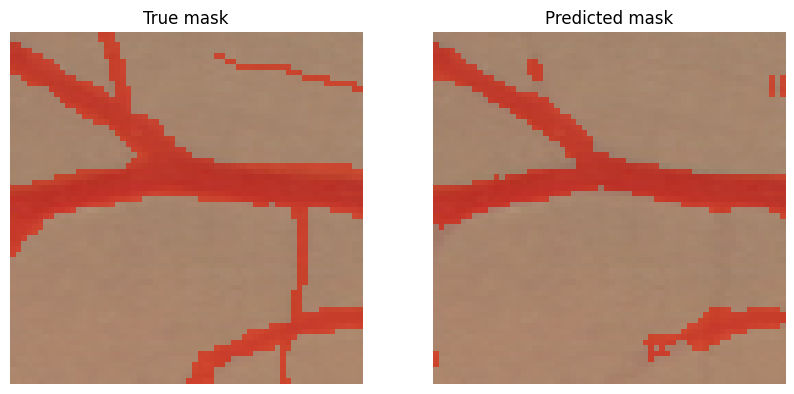

hist:
[[3119.   35.]
 [ 297.  645.]],
iou:[0.903796   0.66018424],
miou:0.7819901193103507,
PA:0.9189453125,
cPA:[0.98890298 0.68471338],
mPA:0.8368081780693003
clDice: 0.24060273170471191
----------------------------------------
36_training.tif:


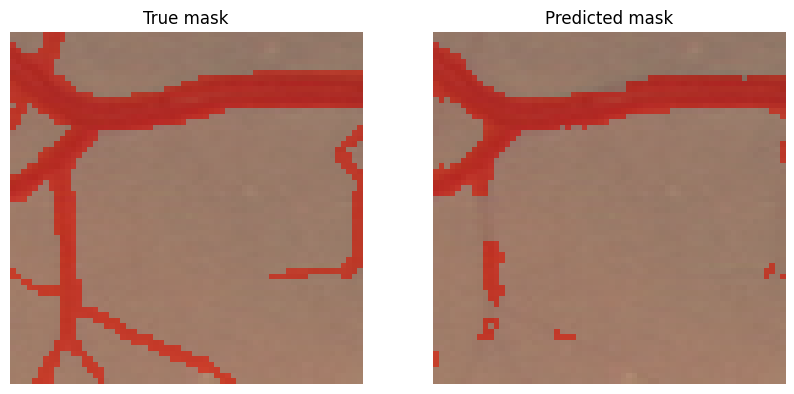

hist:
[[3173.   29.]
 [ 348.  546.]],
iou:[0.89380282 0.5915493 ],
miou:0.7426760563380281,
PA:0.907958984375,
cPA:[0.99094316 0.61073826],
mPA:0.8008407077791146
clDice: 0.3097243309020996
----------------------------------------
40_training.tif:


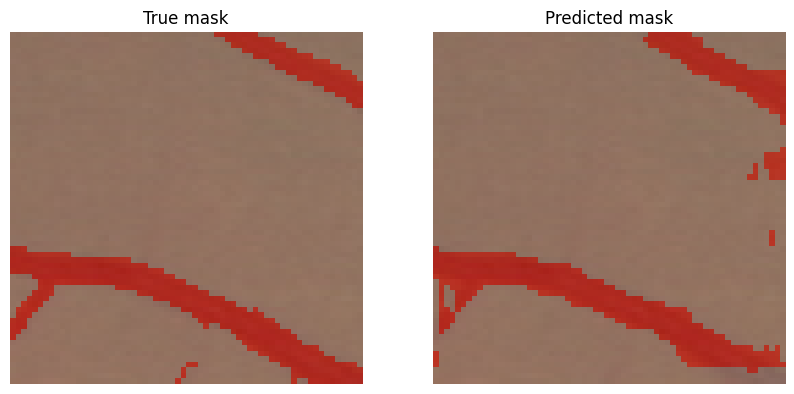

hist:
[[3440.  132.]
 [  75.  449.]],
iou:[0.94324102 0.68445122],
miou:0.8138461197643234,
PA:0.949462890625,
cPA:[0.96304591 0.85687023],
mPA:0.9099580708308044
clDice: 0.16469621658325195
----------------------------------------
33_training.tif:


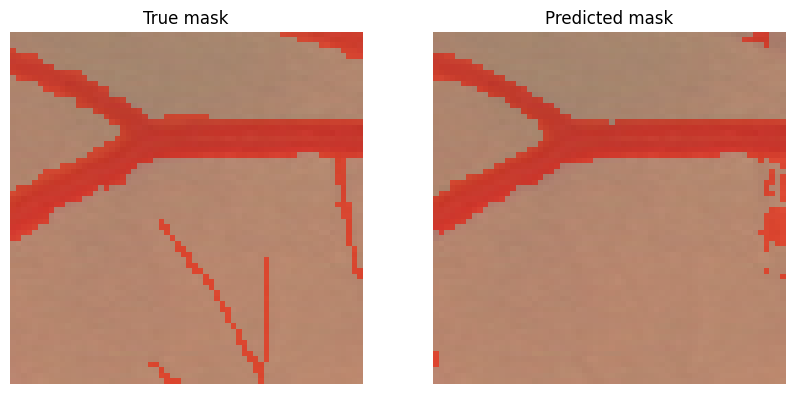

hist:
[[3298.   47.]
 [ 179.  572.]],
iou:[0.93586833 0.71679198],
miou:0.8263301556957092,
PA:0.94482421875,
cPA:[0.98594918 0.76165113],
mPA:0.8738001548508316
clDice: 0.33069908618927
----------------------------------------
37_training.tif:


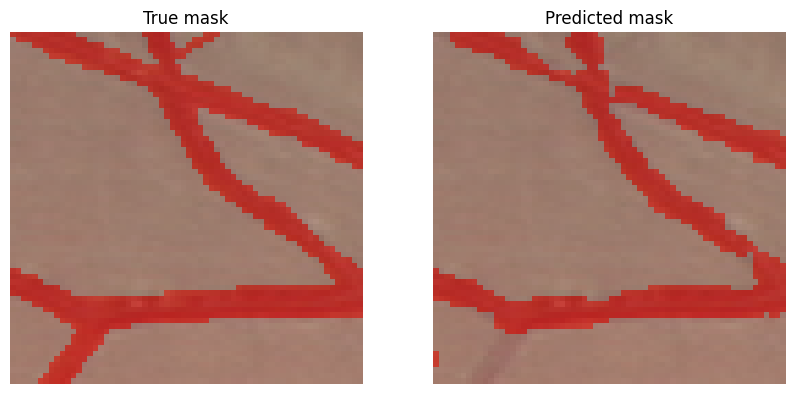

hist:
[[3042.   61.]
 [ 194.  799.]],
iou:[0.92265696 0.75806452],
miou:0.8403607385012768,
PA:0.937744140625,
cPA:[0.9803416  0.80463243],
mPA:0.8924870159437039
clDice: 0.15226519107818604
----------------------------------------
38_training.tif:


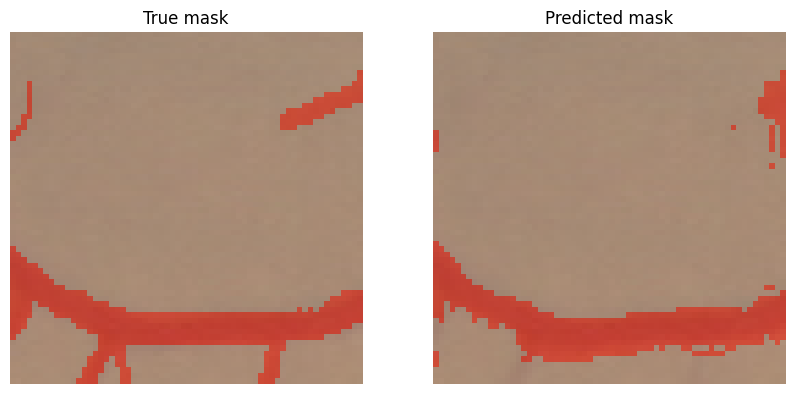

hist:
[[3402.  134.]
 [ 140.  420.]],
iou:[0.92546246 0.60518732],
miou:0.7653248895397515,
PA:0.93310546875,
cPA:[0.96210407 0.75      ],
mPA:0.8560520361990951
clDice: 0.28019481897354126
----------------------------------------
34_training.tif:


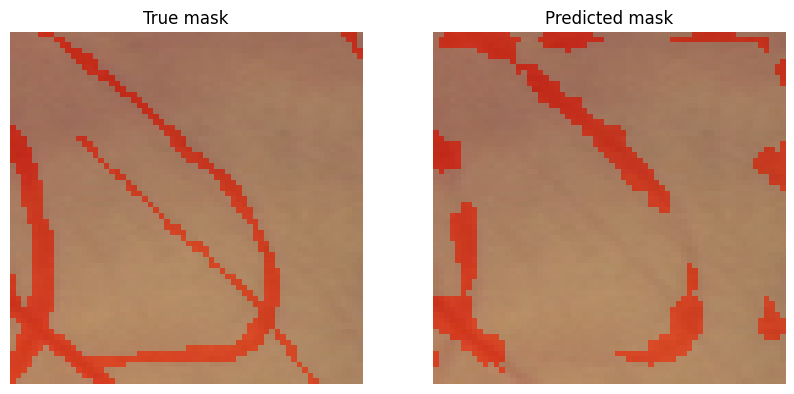

hist:
[[3251.  300.]
 [ 242.  303.]],
iou:[0.85710519 0.35857988],
miou:0.6078425377174084,
PA:0.86767578125,
cPA:[0.91551676 0.5559633 ],
mPA:0.735740029297859
clDice: 0.46077245473861694
----------------------------------------
35_training.tif:


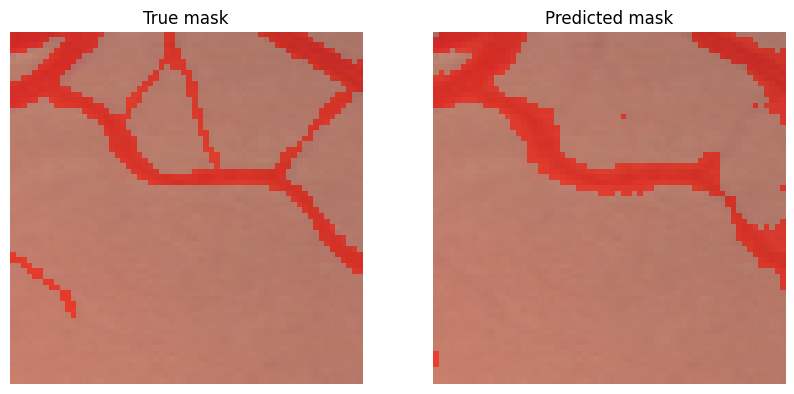

hist:
[[3368.  185.]
 [ 126.  417.]],
iou:[0.91546616 0.5728022 ],
miou:0.7441341785423057,
PA:0.924072265625,
cPA:[0.94793133 0.7679558 ],
mPA:0.8579435633726382
clDice: 0.21558815240859985
----------------------------------------
39_training.tif:


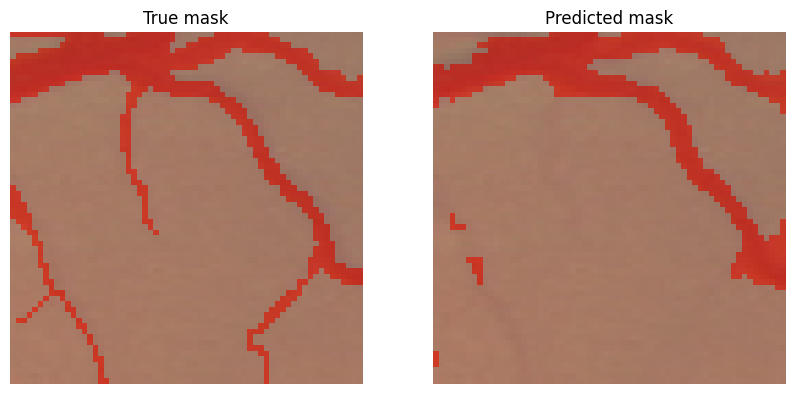

hist:
[[3237.  153.]
 [ 212.  494.]],
iou:[0.89866741 0.57508731],
miou:0.7368773589113279,
PA:0.910888671875,
cPA:[0.95486726 0.69971671],
mPA:0.827291985259094
clDice: 0.362404465675354
----------------------------------------
32_training.tif:


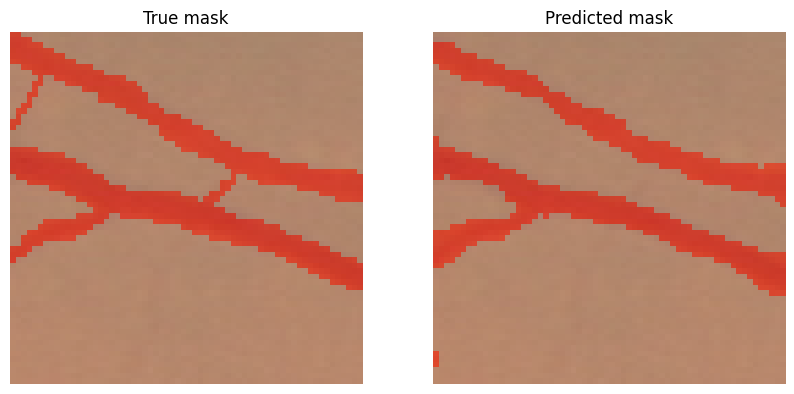

hist:
[[3215.   86.]
 [ 150.  645.]],
iou:[0.93161402 0.73212259],
miou:0.8318683064442655,
PA:0.9423828125,
cPA:[0.97394729 0.81132075],
mPA:0.8926340217086874
clDice: 0.16226619482040405
----------------------------------------


In [ ]:
mean_metric_train = {'IoU':[], 'PA':[], 'clDice':[]}

for i, (x, y) in enumerate(train_set):
    pred = evaluate_model_on_single_image(model, x)

    print(imLst_train[i]+':')

    # Plot the result
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
    ax1.set_title("True mask")
    ax2.set_title("Predicted mask")
    plot_image_with_segmentation(x, y, ax=ax1, model='rgb')
    plot_image_with_segmentation(x, pred, ax=ax2, model='rgb')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()

    # save result
    segm = pred.cpu().detach().numpy()
    segm[segm < threshold] = 0
    segm[segm >= threshold] = 255
    mask = segm.squeeze()

    cldice = eval_loss_func(pred.to(device), y.unsqueeze(0).to(device)).cpu().detach().numpy().item()

    pred_mask = torch.where(pred > threshold, torch.ones_like(pred), torch.zeros_like(pred))
    pred_mask, real_mask = pred_mask.cpu().numpy().squeeze(), y.cpu().numpy().squeeze()
    pred_mask, real_mask = pred_mask.astype(np.int32), real_mask.astype(np.int32)

    metric = SegmentationMetric(2)
    hist = metric.addBatch(pred_mask, real_mask)
    pa = metric.pixelAccuracy()
    cpa = metric.classPixelAccuracy()
    mpa = metric.meanPixelAccuracy()
    IoU = metric.IntersectionOverUnion()
    mIoU = metric.meanIntersectionOverUnion()
    print('hist:\n{},\niou:{},\nmiou:{},\nPA:{},\ncPA:{},\nmPA:{}'.format(hist, IoU, mIoU, pa, cpa, mpa))
    print('clDice:', cldice)
    print('--'*20)

    mean_metric_train['IoU'].append(mIoU)
    mean_metric_train['PA'].append(pa)
    mean_metric_train['clDice'].append(cldice)

    # result = Image.fromarray(mask)
    # result = result.convert('L')
    # result.save("/content/drive/MyDrive/code/Post-Processing/unet/AngioData/train/result/"+"threshold_"+str(threshold)+"/"+imLst_train[i])



# IoU_list = mean_metric_train['IoU']
# PA_list = mean_metric_train['PA']
# clDice_list = mean_metric_train['clDice']
# print('IoU: segm')
# print('  Min IoU: {:.4f}, \n  0.25 IoU: {:.4f}, \n  0.5 IoU: {:.4f}, \n  0.75 IoU: {:.4f}, \n  Max IoU: {:.4f}, \n  mIoU: {:.4f}'
#     .format(np.min(IoU_list), statistics.quantiles(IoU_list, n=4)[0], statistics.quantiles(IoU_list, n=4)[1], statistics.quantiles(IoU_list, n=4)[2], np.max(IoU_list), np.mean(IoU_list)))
# print('PA: segm')
# print('  Min PA: {:.4f}, \n  0.25 PA: {:.4f}, \n  0.5 PA: {:.4f}, \n  0.75 PA: {:.4f}, \n  Max PA: {:.4f}, \n  mPA: {:.4f}'
#     .format(np.min(PA_list), statistics.quantiles(PA_list, n=4)[0], statistics.quantiles(PA_list, n=4)[1], statistics.quantiles(PA_list, n=4)[2], np.max(PA_list), np.mean(PA_list)))

01_test.tif:


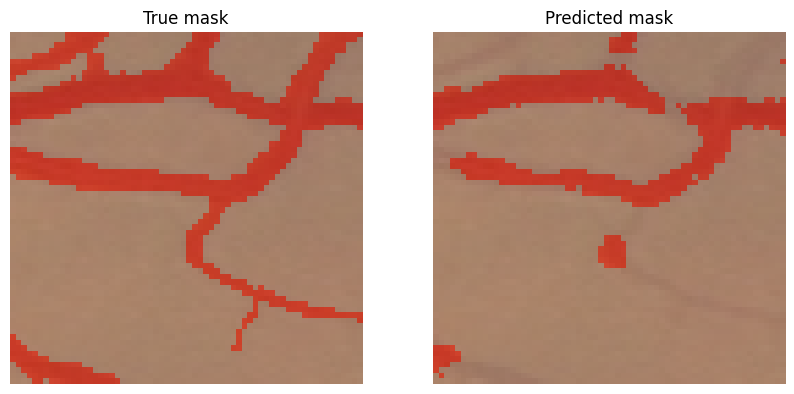

hist:
[[3075.   73.]
 [ 415.  533.]],
iou:[0.86303677 0.52203722],
miou:0.6925369925914482,
PA:0.880859375,
cPA:[0.97681067 0.56223629],
mPA:0.7695234801816437
clDice: 0.3069852590560913
----------------------------------------
03_test.tif:


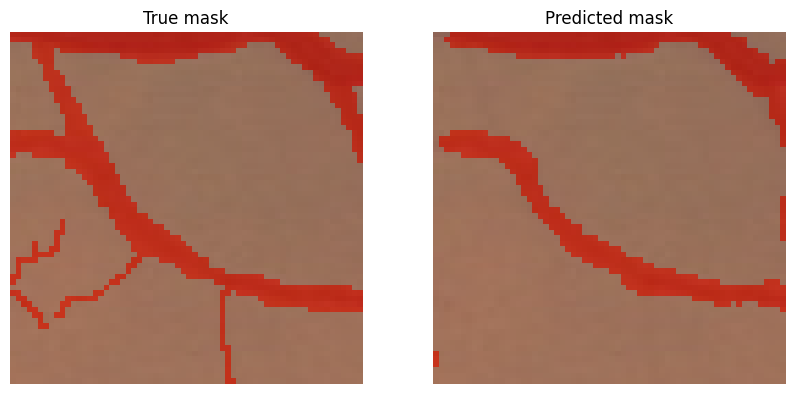

hist:
[[3204.   62.]
 [ 262.  568.]],
iou:[0.90816327 0.6367713 ],
miou:0.7724672828772765,
PA:0.9208984375,
cPA:[0.98101653 0.68433735],
mPA:0.8326769416920592
clDice: 0.2646474838256836
----------------------------------------
02_test.tif:


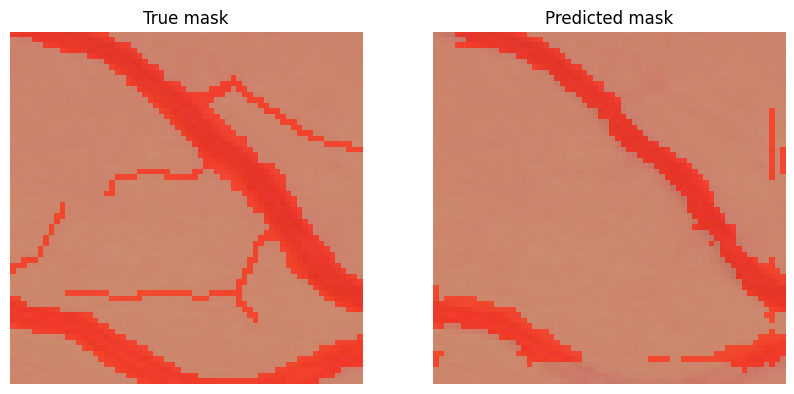

hist:
[[3086.   85.]
 [ 421.  504.]],
iou:[0.8591314 0.4990099],
miou:0.6790706520540695,
PA:0.87646484375,
cPA:[0.97319458 0.54486486],
mPA:0.7590297203542237
clDice: 0.46967387199401855
----------------------------------------
13_test.tif:


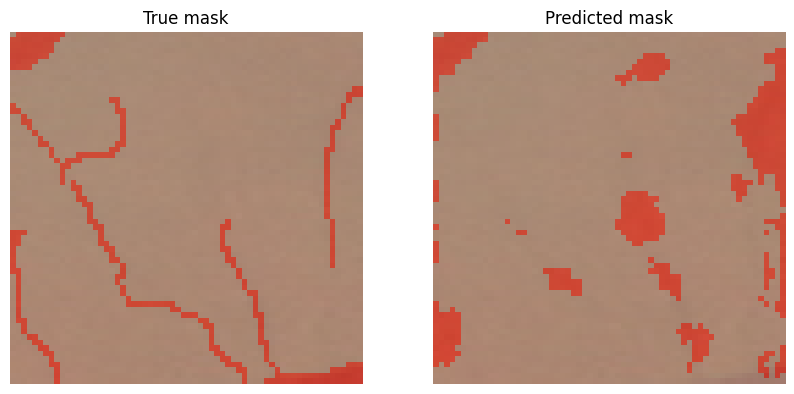

hist:
[[3385.  399.]
 [ 205.  107.]],
iou:[0.8485836  0.15049226],
miou:0.4995379346649136,
PA:0.8525390625,
cPA:[0.89455603 0.34294872],
mPA:0.6187523716593484
clDice: 0.730471134185791
----------------------------------------
09_test.tif:


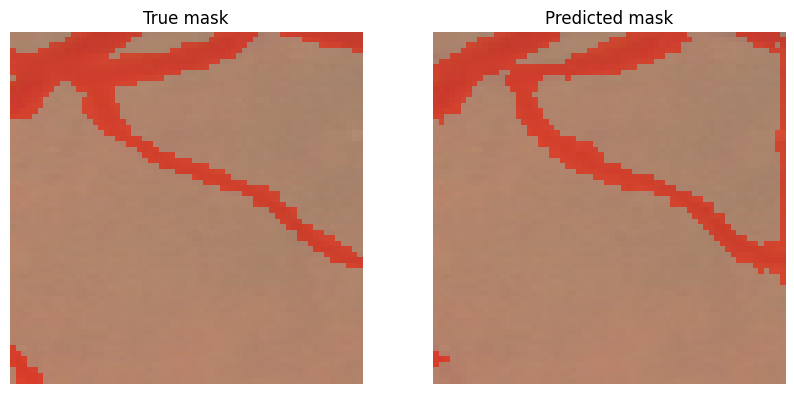

hist:
[[3367.  146.]
 [ 111.  472.]],
iou:[0.92908389 0.64746228],
miou:0.7882730811508099,
PA:0.937255859375,
cPA:[0.95844008 0.80960549],
mPA:0.8840227842773642
clDice: 0.2592756152153015
----------------------------------------
08_test.tif:


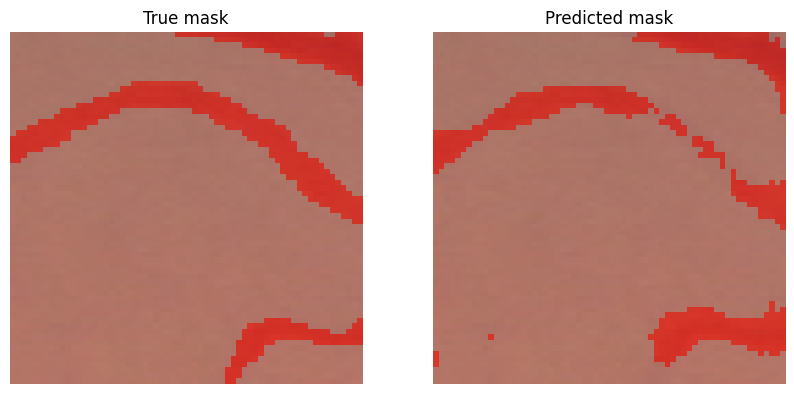

hist:
[[3376.  124.]
 [ 158.  438.]],
iou:[0.92290869 0.60833333],
miou:0.7656210133041734,
PA:0.93115234375,
cPA:[0.96457143 0.73489933],
mPA:0.8497353787152444
clDice: 0.16045725345611572
----------------------------------------
06_test.tif:


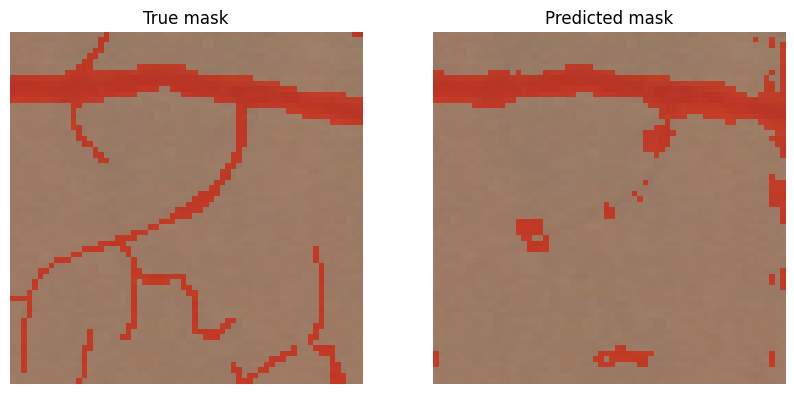

hist:
[[3344.  165.]
 [ 248.  339.]],
iou:[0.89007187 0.45079787],
miou:0.670434869095419,
PA:0.899169921875,
cPA:[0.95297806 0.57751278],
mPA:0.765245416628839
clDice: 0.505062997341156
----------------------------------------
10_test.tif:


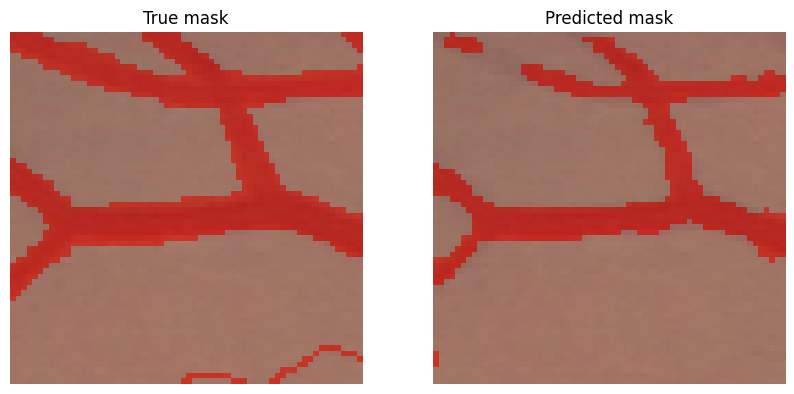

hist:
[[2990.   16.]
 [ 386.  704.]],
iou:[0.88148585 0.63652803],
miou:0.759006938994848,
PA:0.90185546875,
cPA:[0.99467731 0.64587156],
mPA:0.8202744358378045
clDice: 0.23197436332702637
----------------------------------------
12_test.tif:


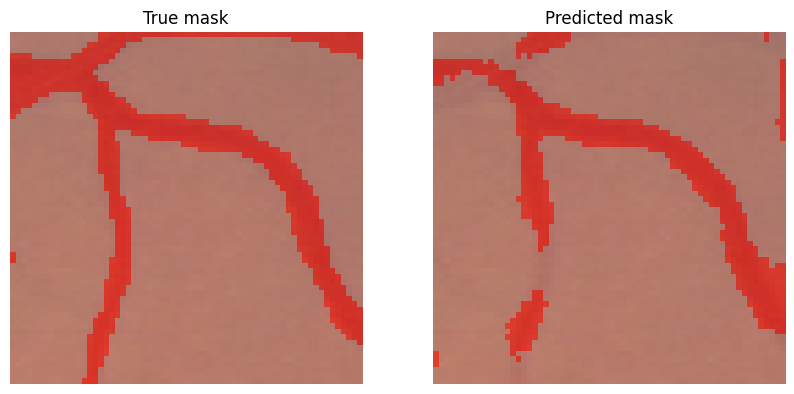

hist:
[[3229.  122.]
 [ 233.  512.]],
iou:[0.90094866 0.5905421 ],
miou:0.7457453799534519,
PA:0.913330078125,
cPA:[0.96359296 0.68724832],
mPA:0.8254206397369112
clDice: 0.25818347930908203
----------------------------------------
04_test.tif:


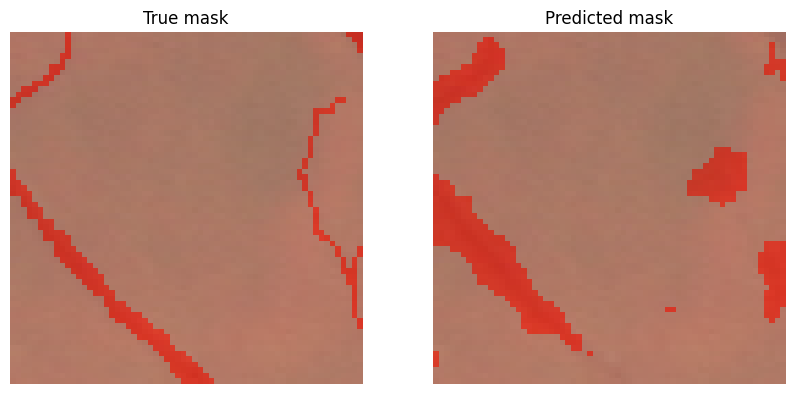

hist:
[[3520.  325.]
 [  80.  171.]],
iou:[0.89681529 0.296875  ],
miou:0.5968451433121019,
PA:0.901123046875,
cPA:[0.91547464 0.6812749 ],
mPA:0.798374771395562
clDice: 0.3872387409210205
----------------------------------------
07_test.tif:


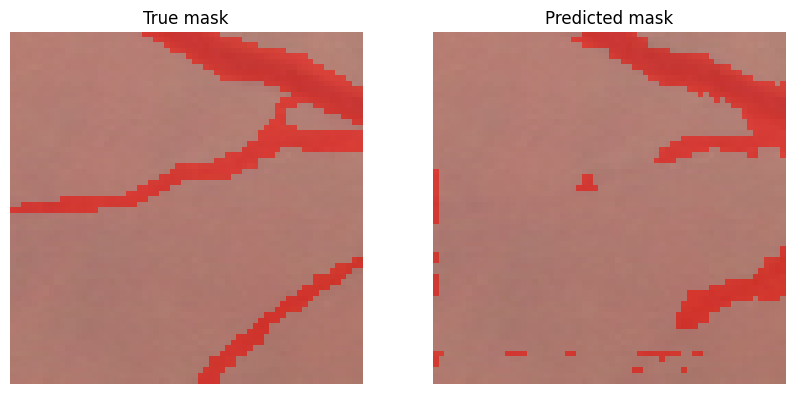

hist:
[[3378.  131.]
 [ 238.  349.]],
iou:[0.90152122 0.48607242],
miou:0.6937968201859538,
PA:0.909912109375,
cPA:[0.96266743 0.59454855],
mPA:0.7786079892881921
clDice: 0.36186593770980835
----------------------------------------
11_test.tif:


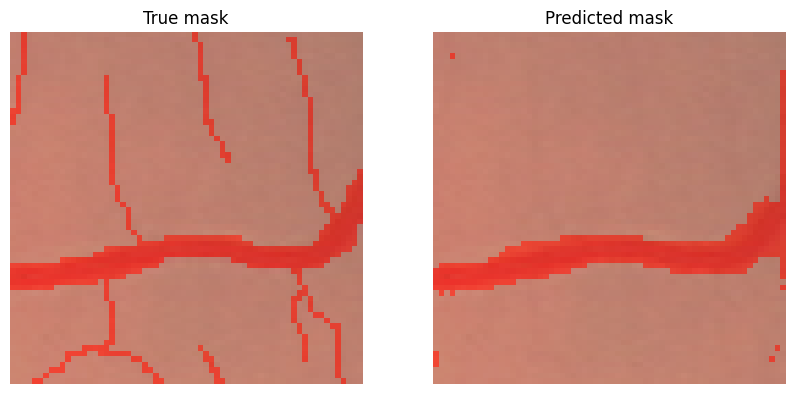

hist:
[[3441.  119.]
 [ 213.  323.]],
iou:[0.91200636 0.49312977],
miou:0.7025680659891596,
PA:0.9189453125,
cPA:[0.96657303 0.60261194],
mPA:0.7845924870031864
clDice: 0.4694153666496277
----------------------------------------
14_test.tif:


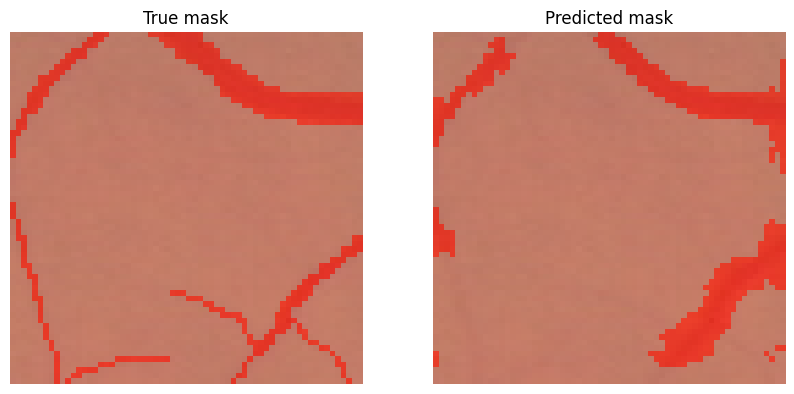

hist:
[[3422.  230.]
 [ 145.  299.]],
iou:[0.90123782 0.44362018],
miou:0.6724289986862969,
PA:0.908447265625,
cPA:[0.93702081 0.67342342],
mPA:0.805222116969105
clDice: 0.38823258876800537
----------------------------------------
15_test.tif:


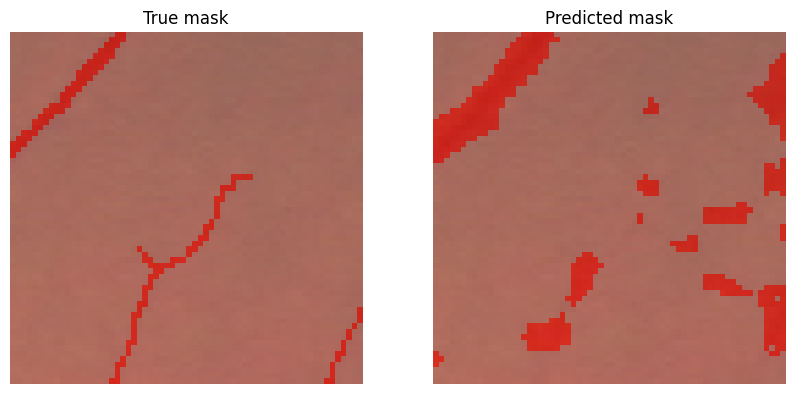

hist:
[[3571.  374.]
 [  47.  104.]],
iou:[0.89453908 0.19809524],
miou:0.5463171581257753,
PA:0.897216796875,
cPA:[0.90519645 0.68874172],
mPA:0.7969690865291802
clDice: 0.580391526222229
----------------------------------------
05_test.tif:


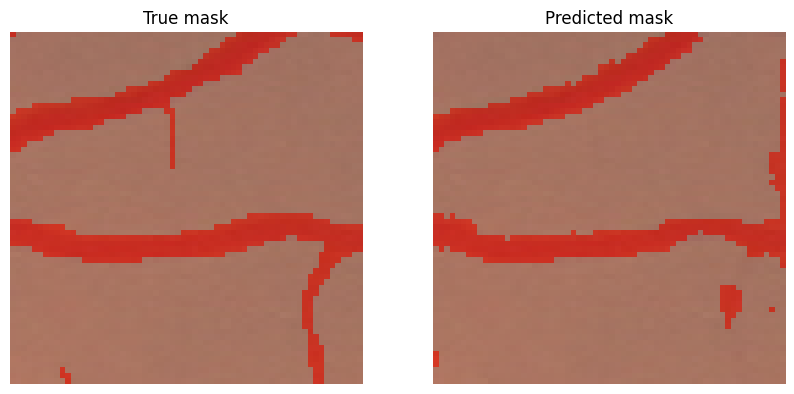

hist:
[[3309.  109.]
 [ 137.  541.]],
iou:[0.93080169 0.68742058],
miou:0.8091111361309036,
PA:0.93994140625,
cPA:[0.96811001 0.7979351 ],
mPA:0.8830225545481064
clDice: 0.2613264322280884
----------------------------------------
19_test.tif:


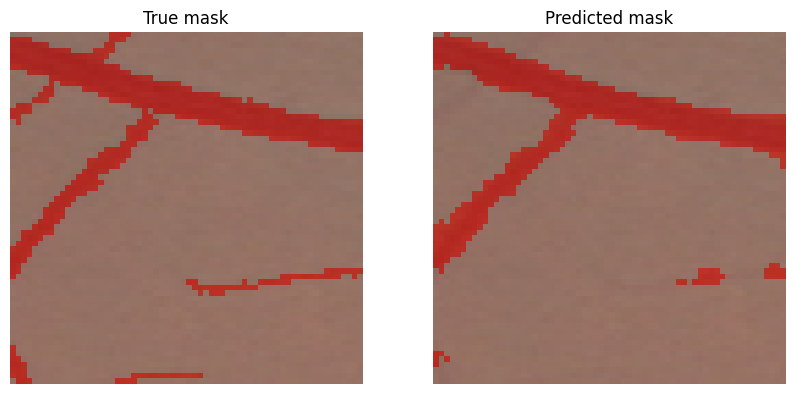

hist:
[[3361.  110.]
 [ 117.  508.]],
iou:[0.93673356 0.69115646],
miou:0.8139450094419038,
PA:0.944580078125,
cPA:[0.96830884 0.8128    ],
mPA:0.8905544223566695
clDice: 0.18058693408966064
----------------------------------------
17_test.tif:


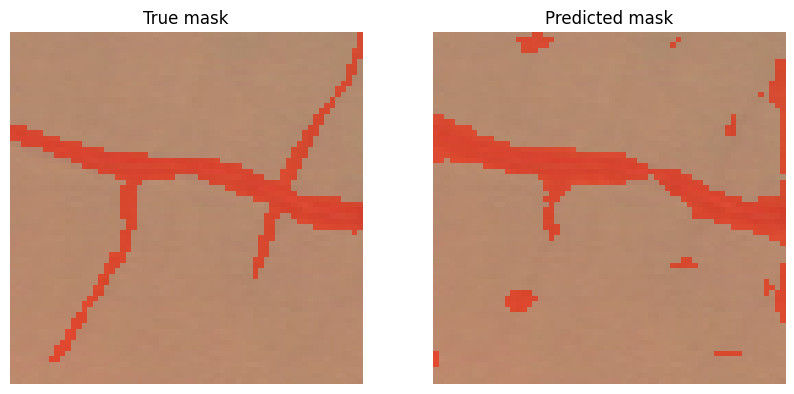

hist:
[[3445.  208.]
 [ 138.  305.]],
iou:[0.90873121 0.46850998],
miou:0.6886205950628479,
PA:0.91552734375,
cPA:[0.9430605  0.68848758],
mPA:0.8157740414353767
clDice: 0.36977237462997437
----------------------------------------
20_test.tif:


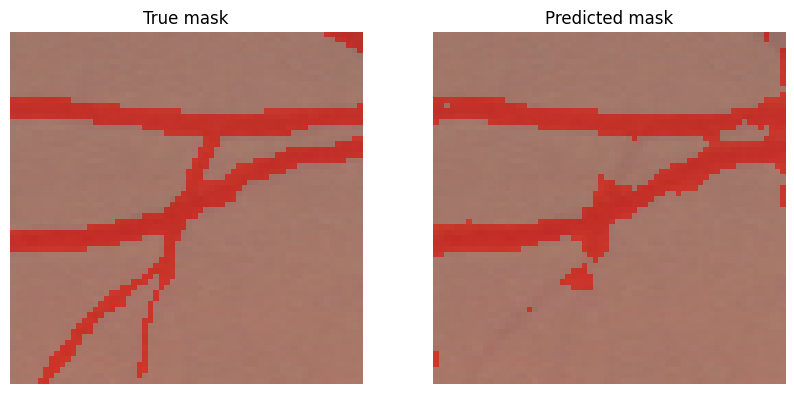

hist:
[[3289.  138.]
 [ 157.  512.]],
iou:[0.91768973 0.63444857],
miou:0.7760691535559391,
PA:0.927978515625,
cPA:[0.95973154 0.76532138],
mPA:0.8625264594055035
clDice: 0.2317999005317688
----------------------------------------
16_test.tif:


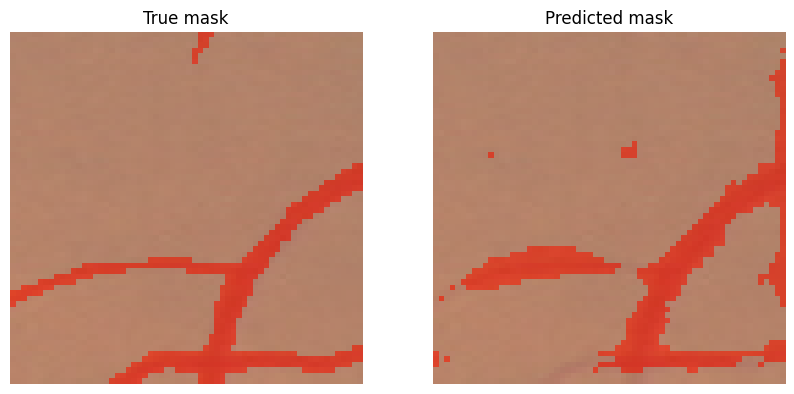

hist:
[[3409.  251.]
 [ 113.  323.]],
iou:[0.90352505 0.47016012],
miou:0.6868425814152577,
PA:0.9111328125,
cPA:[0.93142077 0.74082569],
mPA:0.8361232265503584
clDice: 0.30799227952957153
----------------------------------------
18_test.tif:


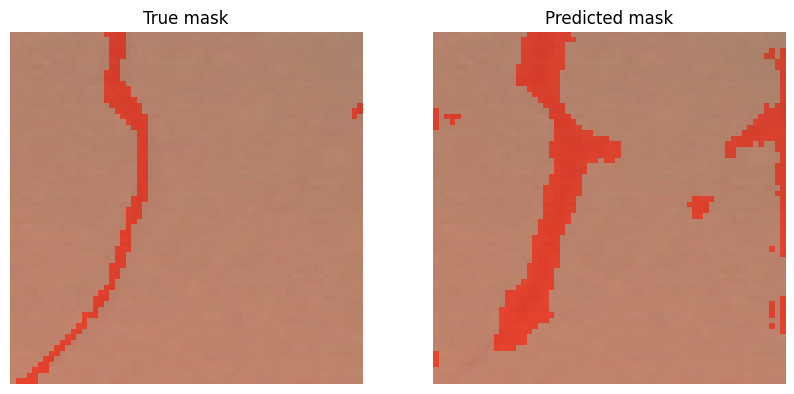

hist:
[[3538.  387.]
 [  30.  141.]],
iou:[0.89456384 0.25268817],
miou:0.5736260076397102,
PA:0.898193359375,
cPA:[0.90140127 0.8245614 ],
mPA:0.8629813386970611
clDice: 0.4817986488342285
----------------------------------------


In [ ]:
toPIL = transforms.ToPILImage()
mean_metric_test = {'IoU':[], 'PA':[], 'clDice':[]}
for i, (x, y) in enumerate(test_set):
    pred = evaluate_model_on_single_image(model, x)

    print(imLst_test[i]+':')

    # Plot the result
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
    ax1.set_title("True mask")
    ax2.set_title("Predicted mask")
    plot_image_with_segmentation(x, y, ax=ax1, model='rgb')
    plot_image_with_segmentation(x, pred, ax=ax2, model='rgb')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()

    # save result
    segm = pred.cpu().detach().numpy()
    segm[segm < threshold] = 0
    segm[segm >= threshold] = 255
    mask = segm.squeeze()

    pred_mask = torch.where(pred > threshold, torch.ones_like(pred), torch.zeros_like(pred))
    pred_mask, real_mask = pred_mask.cpu().numpy().squeeze(), y.cpu().numpy().squeeze()
    pred_mask, real_mask = pred_mask.astype(np.int32), real_mask.astype(np.int32)

    cldice = eval_loss_func(pred.to(device), y.unsqueeze(0).to(device)).cpu().detach().numpy().item()

    metric = SegmentationMetric(2)
    hist = metric.addBatch(pred_mask, real_mask)
    pa = metric.pixelAccuracy()
    cpa = metric.classPixelAccuracy()
    mpa = metric.meanPixelAccuracy()
    IoU = metric.IntersectionOverUnion()
    mIoU = metric.meanIntersectionOverUnion()
    print('hist:\n{},\niou:{},\nmiou:{},\nPA:{},\ncPA:{},\nmPA:{}'.format(hist, IoU, mIoU, pa, cpa, mpa))
    print('clDice:', cldice)
    print('--'*20)

    mean_metric_test['IoU'].append(mIoU)
    mean_metric_test['PA'].append(pa)
    mean_metric_test['clDice'].append(cldice)

    # result = Image.fromarray(mask)
    # result = result.convert('L')
    # result.save("/content/drive/MyDrive/code/Post-Processing/unet/AngioData/test/result/"+"threshold_"+str(threshold)+"/"+imLst_test[i])

# IoU_list = mean_metric_test['IoU']
# PA_list = mean_metric_test['PA']
# clDice_list = mean_metric_test['clDice']
# print('IoU: segm')
# print('  Min IoU: {:.4f}, \n  0.25 IoU: {:.4f}, \n  0.5 IoU: {:.4f}, \n  0.75 IoU: {:.4f}, \n  Max IoU: {:.4f}, \n  mIoU: {:.4f}'
#     .format(np.min(IoU_list), statistics.quantiles(IoU_list, n=4)[0], statistics.quantiles(IoU_list, n=4)[1], statistics.quantiles(IoU_list, n=4)[2], np.max(IoU_list), np.mean(IoU_list)))
# print('PA: segm')
# print('  Min PA: {:.4f}, \n  0.25 PA: {:.4f}, \n  0.5 PA: {:.4f}, \n  0.75 PA: {:.4f}, \n  Max PA: {:.4f}, \n  mPA: {:.4f}'
#     .format(np.min(PA_list), statistics.quantiles(PA_list, n=4)[0], statistics.quantiles(PA_list, n=4)[1], statistics.quantiles(PA_list, n=4)[2], np.max(PA_list), np.mean(PA_list)))


In [ ]:
# print('threshold:', threshold)
print(mean_metric_train)
print(mean_metric_test)
# print('--'*20)

{'IoU': [0.7031672658186724, 0.8355502080143264, 0.7087018875702042, 0.7642834128294679, 0.7620242953133982, 0.7847245138518562, 0.5107850051192292, 0.6652370871877746, 0.8699484297448747, 0.8005563360846986, 0.7819901193103507, 0.7426760563380281, 0.8138461197643234, 0.8263301556957092, 0.8403607385012768, 0.7653248895397515, 0.6078425377174084, 0.7441341785423057, 0.7368773589113279, 0.8318683064442655], 'PA': [0.916748046875, 0.93798828125, 0.907470703125, 0.918701171875, 0.9296875, 0.927490234375, 0.877685546875, 0.928466796875, 0.956298828125, 0.92919921875, 0.9189453125, 0.907958984375, 0.949462890625, 0.94482421875, 0.937744140625, 0.93310546875, 0.86767578125, 0.924072265625, 0.910888671875, 0.9423828125], 'clDice': [0.37116605043411255, 0.08325773477554321, 0.38714534044265747, 0.25481653213500977, 0.31071406602859497, 0.2732424736022949, 0.7498522996902466, 0.4505416750907898, 0.21447443962097168, 0.17130005359649658, 0.24060273170471191, 0.3097243309020996, 0.164696216583251

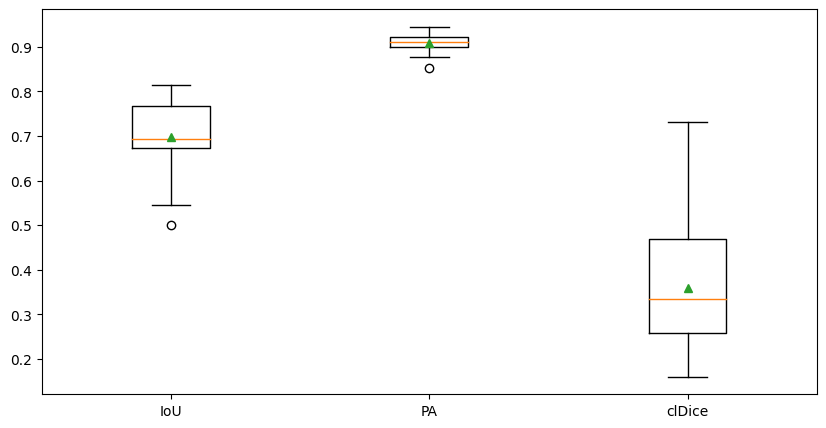

In [ ]:
box_1, box_2, box_3 = mean_metric_test['IoU'], mean_metric_test['PA'], mean_metric_test['clDice']

plt.figure(figsize=(10,5))
# plt.title('Examples of boxplot',fontsize=15)
labels = ['IoU','PA','clDice']
plt.boxplot([box_1, box_2, box_3], labels = labels, showmeans=True)
# plt.legend()
plt.show()

In [ ]:
def remove_outliers(data, min, max):
    # 确保数据是 NumPy 数组
    data = np.array(data)

    # 计算第5和第95百分位数
    q_low = np.percentile(data, min)
    q_high = np.percentile(data, max)

    # 过滤掉低于第5百分位和高于第95百分位的数据点
    filtered_data = data[(data >= q_low) & (data <= q_high)]
    return filtered_data


In [ ]:
iou_clean = mean_metric_train['IoU']
pa_clean = mean_metric_train['PA']
cldice_clean = remove_outliers(mean_metric_train['clDice'], 10, 90)

In [ ]:
print(np.mean(iou_clean))
print(np.mean(pa_clean))
print(np.mean(cldice_clean))

0.7548114451149625
0.92333984375
0.28122353926301


In [ ]:
print(np.median(iou_clean))
print(np.median(pa_clean))
print(np.median(cldice_clean))

0.7648041511846098
0.927978515625
0.2767186462879181


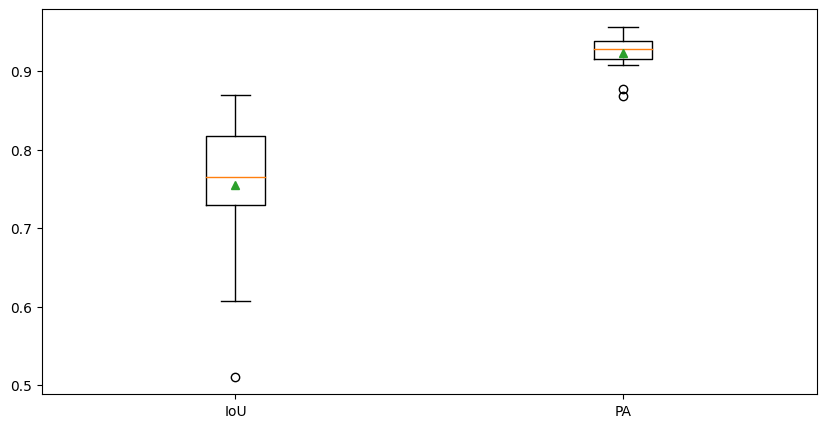

In [ ]:
box_1, box_2 = iou_clean, pa_clean

plt.figure(figsize=(10,5))
# plt.title('Examples of boxplot',fontsize=15)
labels = ['IoU','PA']
plt.boxplot([box_1, box_2], labels = labels, showmeans=True)
# plt.legend()
plt.show()

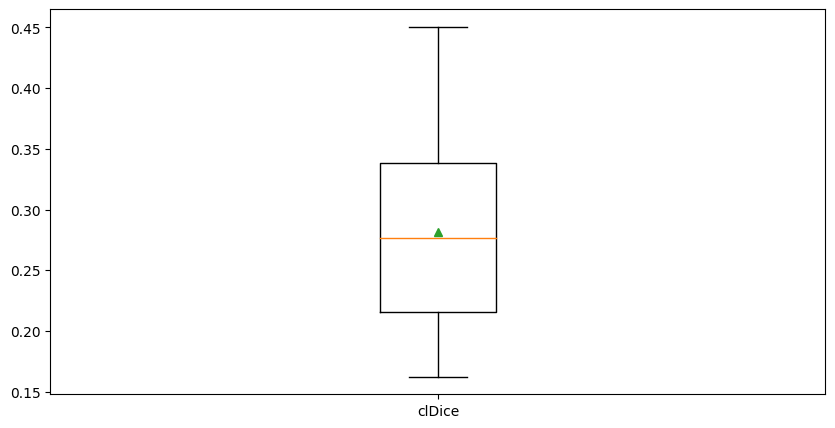

In [ ]:
box_1 = cldice_clean

plt.figure(figsize=(10,5))
# plt.title('Examples of boxplot',fontsize=15)
labels = ['clDice']
plt.boxplot([box_1], labels = labels, showmeans=True)
# plt.legend()
plt.show()

In [ ]:
print(np.std(iou_clean))
print(np.std(pa_clean))
print(np.std(cldice_clean))

0.08371335637468257
0.021377017812687645
0.08279722772265764
